## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date']= pd.to_datetime(data['date'])

print('Дата начала наблюдений: \n', data.groupby('group')['date'].agg(min), '\n')
print('Дата завершения наблюдений: \n', data.groupby('group')['date'].agg(max))


Дата начала наблюдений: 
 group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns] 

Дата завершения наблюдений: 
 group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
print('Посещений: \n', data.groupby('group')['user_id'].agg('count'), '\n')
print('Количество покупок: \n', data.groupby('group')['purchase'].agg('sum'), '\n')
print('Сумма покупок: \n', data.groupby('group')['price'].agg('sum')/1000000)

Посещений: 
 group
A    147202
B    147276
Name: user_id, dtype: int64 

Количество покупок: 
 group
A    17723
B    17514
Name: purchase, dtype: int64 

Сумма покупок: 
 group
A    1436.26
B    1554.10
Name: price, dtype: float64


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
users_A=set(data['user_id'][data['group']== 'A'])
users_B=set(data['user_id'][data['group']== 'B'])
user_intersection=(users_A.intersection(users_B))
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

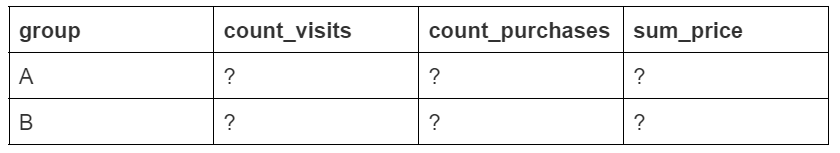
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [30]:
sum_data=updated_data.groupby('group').agg({
                        'user_id':'count',
                        'purchase':'sum',
                        'price':'sum'   
                }).reset_index().rename(columns={
                        'user_id':'count_visits',
                        'purchase':'count_purchases',
                        'price':'sum_price'
                })
sum_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество посещений в обоих вариантах отличается менее чем на 0.001%. Ввиду столь незначительной разницы, можем сделать вывод о сопоставимом размере выборок. Т.к. пользователи, встречающиеся в обеих выборках были исключены из исследуемых данных, можем говорить о сбалансированности датасета.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [40]:
sum_data['convertion']=round(sum_data['count_purchases']/sum_data['count_visits']*100, 2)
sum_data['mean_check']=round(sum_data['sum_price']/sum_data['count_purchases'])
sum_data


,group,count_visits,count_purchases,sum_price,convertion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Конверсия в группе А выше всего на 0,12%, однако средний чек в группе В больше примерно на 9%

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [94]:
price_depend=updated_data.groupby(['price', 'group']).agg({
                        'user_id':'count'
                }).reset_index().rename(columns={
                        'user_id':'clients_amount'})

price_depend=price_depend.drop(index=[0,1]).reset_index().drop('index', axis=1)

price_depend

,price,group,clients_amount
0,10000,A,5182
1,10000,B,5201
2,60000,A,5271
3,60000,B,1730
4,100000,A,1832
5,100000,B,5227
6,150000,A,3478
7,150000,B,3438
8,200000,A,1724
9,200000,B,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

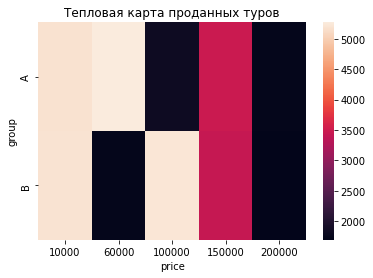

In [98]:
pivot_price=price_depend.pivot_table(
        values='clients_amount',
        index='group',
        columns='price'
        )

heatmap_price=sns.heatmap(data=pivot_price)
heatmap_price.set_title('Тепловая карта проданных туров', fontsize=12);


Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Покупательная способность группы В значительно выше в категории туров с ценой 100'000 рублей, в то время как в группе А больше было куплено туров с ценой 60'000. По остальным группам туров разница не значительна.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [121]:
sum_by_day=updated_data.groupby(['date', 'group']).agg({
                    'user_id':'count',
                    'purchase':'sum',
                    'price':'sum'
                            }).reset_index().rename(columns={
                    'user_id':'count_visits',
                    'purchase':'count_purchases',
                    'price':'sum_price'
                            })
sum_by_day['conversion']=round(sum_by_day['count_purchases']/sum_by_day['count_visits']*100, 2)
sum_by_day['mean_check']=round(sum_by_day['sum_price']/sum_by_day['count_purchases'])
sum_by_day[sum_by_day['date']=='2021-01-03']

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [122]:
sum_by_day['cum_clients_amount']=sum_by_day.groupby('group')['count_visits'].cumsum()
sum_by_day['cum_count_purchases']=sum_by_day.groupby('group')['count_purchases'].cumsum()
sum_by_day['cum_sum_purchases']=sum_by_day.groupby('group')['sum_price'].cumsum()

sum_by_day['cum_conversion']=round(sum_by_day['cum_count_purchases']/sum_by_day['cum_clients_amount']*100, 2)
sum_by_day['cum_mean_check']=round(sum_by_day['cum_sum_purchases']/sum_by_day['cum_count_purchases'])

display(sum_by_day[sum_by_day['date']=='2021-01-20'])
display(sum_by_day[sum_by_day['date']=='2021-01-12'])

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_clients_amount,cum_count_purchases,cum_sum_purchases,cum_conversion,cum_mean_check
36,2021-01-20,A,6533,749,58710000,11.46,78385.0,121506,14561,1179590000,11.98,81010.0
37,2021-01-20,B,6685,790,69250000,11.82,87658.0,121857,14496,1286900000,11.90,88776.0


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_clients_amount,cum_count_purchases,cum_sum_purchases,cum_conversion,cum_mean_check
20,2021-01-12,A,6540,795,68460000,12.16,86113.0,68852,8198,668070000,11.91,81492.0
21,2021-01-12,B,6635,807,70560000,12.16,87435.0,69251,8236,727670000,11.89,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

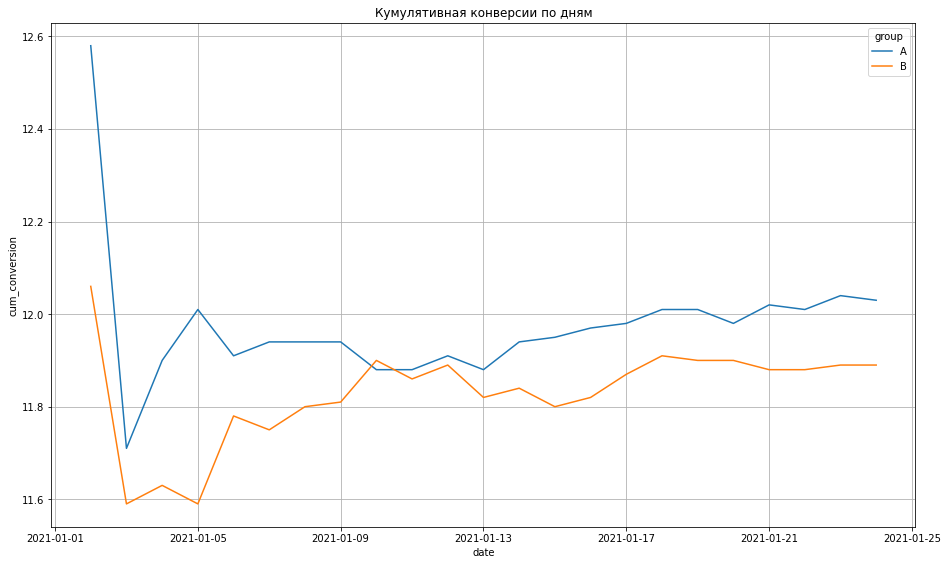

In [132]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=sum_by_day, hue='group', ax=ax)
ax.set_title('Кумулятивная конверсии по дням')
ax.grid(True);

A/B тест можно считать завершенным, т.к. кумулятивные метрики стабилизировались и +/- представляют собой прямую линию. Кумулятивная конверсия в группе А несколько больше, чем в группе В, однако абсолютная разница невелика.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [137]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 

sum_piv= sum_by_day.groupby('group')[['count_purchases','count_visits']].agg('sum')
display(sum_piv)

_, p_value = proportions_ztest(
    count=sum_piv['count_purchases'], 
    nobs=sum_piv['count_visits'], 
    alternative='larger',
)
print('p-value: ', round(p_value, 2))


,count_purchases,count_visits
group,,
A,17487,145307
B,17290,145381


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

т.к. p-value больше уровня значимости, нулевую гипотезу принимаем, конверсии в группах А и B равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [165]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

data_a = updated_data[updated_data['group'] == 'A']
data_b = updated_data[updated_data['group'] == 'B']

conf_interval_a=proportions_conf_interval(
    n=data_a['user_id'].count(),
    x_p=data_a['purchase'].mean()
)

conf_interval_b=proportions_conf_interval(
    n=data_b['user_id'].count(),
    x_p=data_b['purchase'].mean()
)

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))


def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma 
    diff = xp[1] - xp[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [data_a['user_id'].count(), data_b['user_id'].count()]
xp = [data_a['purchase'].mean(), data_b['purchase'].mean()]
print('Доверительный интервал для разности конверсий: {}'.format(diff_proportions_conf_interval(n, xp)))


Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Интервал охватывает точку 0, статистической разницы нет.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [173]:

H0 = 'Распределение нормальное'
H1 = 'Распределение отлично от нормального'
alpha = 0.05
sum_by_day_A=sum_by_day['mean_check'][sum_by_day['group']=='A']
sum_by_day_B=sum_by_day['mean_check'][sum_by_day['group']=='B']

shapiro_a=shapiro(sum_by_day_A)
shapiro_b=shapiro(sum_by_day_B)

if shapiro_a.pvalue < alpha or shapiro_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [177]:
# ваш код здесь
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B.'
alpha = 0.05

result=ttest_ind(
    a=sum_by_day_A,
    b=sum_by_day_B, 
    alternative='less'
)
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу о том, что {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


Отвергаем нулевую гипотезу о том, что Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B.


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Ежедневный средний чек в группе А меньше, чем в группе B

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [187]:

def conf_interval_tcrit(df):
    gamma = 0.95
    alpha = 1 - gamma
    n=len(df)
    k = n - 1
    x_mean=df.mean()
    x_std=df.std()
    t_crit = -t.ppf(alpha/2, k) 
    eps = t_crit * x_std/(n ** 0.5) 
    lower_bound = x_mean - eps 
    upper_bound = x_mean + eps 
    return (round(lower_bound), round(upper_bound))

conf_int_A=conf_interval_tcrit(sum_by_day_A)
conf_int_B=conf_interval_tcrit(sum_by_day_B)

print('Доверительный интервал A: {}'.format(conf_int_A))
print('Доверительный интервал B: {}'.format(conf_int_B))

Доверительный интервал A: (79630, 82308)
Доверительный интервал B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечения интервалов нет. Доверительный интервал среднего чека группы В целиком лежит "правее" интервала группы А. 


## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Разница конверсий между двумя группами оказалась статитстически незначимой, однако по среднему чеку вариант В оказался эффективнее группы А. Так же, кумулятивная сумма продаж группы В выше, чем у группы А.

Исходя из выше изложенного, можем утверждать, что вариант В является более эффективным с точки зрения общей суммы продаж